# Setup
Make a fresh environment:
- `conda create -n VLM python=3.12.3`
- `conda activate VLM`

Install CUDA:
- `conda install -c conda-forge cudatoolkit-dev -y`

Note: I'm running this notebook on an RTX 5060Ti with the goal of hooking it up to ngrok for easy API access

In [1]:
!pip install python-dotenv # For keys
!pip install huggingface_hub # For logging in
!pip install torch transformers # For deep learning
!pip install Pillow # For image processing
!pip install bitsandbytes accelerate # For loading models
!pip install flash-attn --no-build-isolation # For flash attention

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()
hf_key = os.getenv("HF_KEY")

from huggingface_hub import login
login(token=hf_key)
print("Successfully logged in")

/home/chengyi/anaconda3/envs/VLM/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Successfully logged in


Here's an example of what the model might see:

`example.png` 

![example image](example.png)

`example_bad.png` 

![example bad image](example_bad.png)

`example_good.png` 

![example_good image](example_good.png)

In [76]:
example_path = 'images/example.png'
good_example_path = 'images/example_good.png'
bad_example_path = 'images/example_bad.png'

We try to solve the following problems using the VLM:
- Reflection: because LIDAR depends on light to create environmental reconstructions, reflective surfaces pose a problem.
- Phantom objects: objects created due to reflective surfaces in the environment.
- Slopes: Changes in elevation.
- Moving objects: People and cars.
- Confirmation: Is the following path safe?

# Prompting

Download the model

In [ ]:
from transformers import AutoProcessor, AutoModelForVision2Seq
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", DEVICE)

# Takes about 2 mins to download the model on Colab, but 6.5 seconds on PC
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForVision2Seq.from_pretrained("HuggingFaceTB/SmolVLM-Instruct",
                                                dtype=torch.bfloat16,
                                                _attn_implementation="flash_attention_2" if DEVICE == "cuda" else "eager").to(DEVICE)


Using cuda


/home/chengyi/anaconda3/envs/VLM/lib/python3.12/site-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


Prompting the model

In [77]:
# Takes about 4 seconds on Colab's A100 GPU and 1-12 seconds on my PC depending on how much it generates
from PIL import Image
from transformers.image_utils import load_image
import time

# Start
start_time = time.perf_counter()

# Load images
image1 = load_image(example_path)

# Create input messages
messages = [
    {
        "role": "system",
        "content": [
            {"type": "text", "text": "You are a VLM that is designed to detect obstacles to ensure a safe route for wheelchair users."}
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "image"},
            # {"type": "image"}, # If you wanna add a 2nd image this is where to put it
            {"type": "text", "text": "Going forward, are there any obstacles to be aware of?"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image1], return_tensors="pt")
inputs = inputs.to(DEVICE)

# Generate outputs
generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)
print(generated_texts[0])

# End
end_time = time.perf_counter()
run_time = end_time - start_time
print("Runtime: ", round(run_time, 4), "seconds")

System: You are a VLM that is designed to detect obstacles to ensure a safe route for wheelchair users.
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>Going forward, are there any obstacles to be aware of?
Assistant: Yes, there are chairs in the room.
Runtime:  0.8083 seconds


# Same model, try different prompts

In [66]:
system_prompts = ['You are a VLM designed to detect obstacles to ensure a safe route for self-driving wheelchair users.',
                  "You are a VLM designed to detect obstacles to ensure a safe route for self-driving wheelchair users. Please detect any moving objects, slopes, or obstacles in the wheelchair's path",
                  'You are a helpful VLM designed to detect obstacles to ensure a safe route for self-driving wheelchair users.',
                  "You are a helpful VLM designed to detect obstacles to ensure a safe route for self-driving wheelchair users. Please detect any moving objects, slopes, or obstacles in the wheelchair's path"]

Testing system prompts

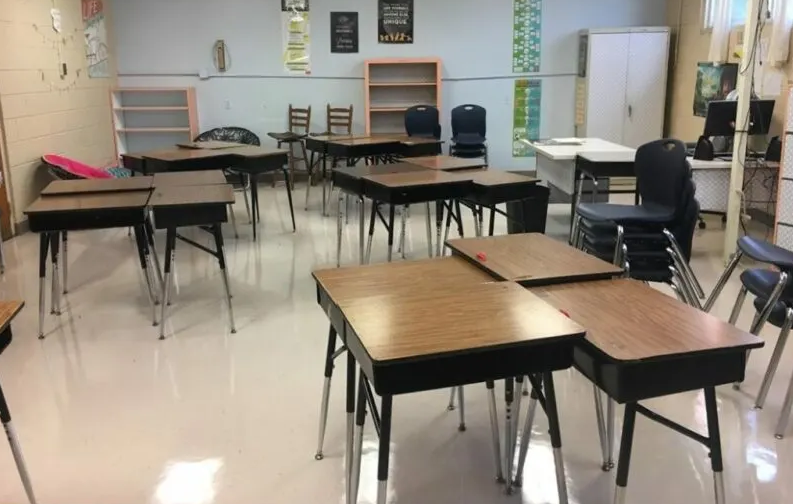

System: You are a VLM designed to detect obstacles to ensure a safe route for self-driving wheelchair users.
Assistant: Yes, there are chairs and desks in the room.
Runtime:  0.8825 seconds



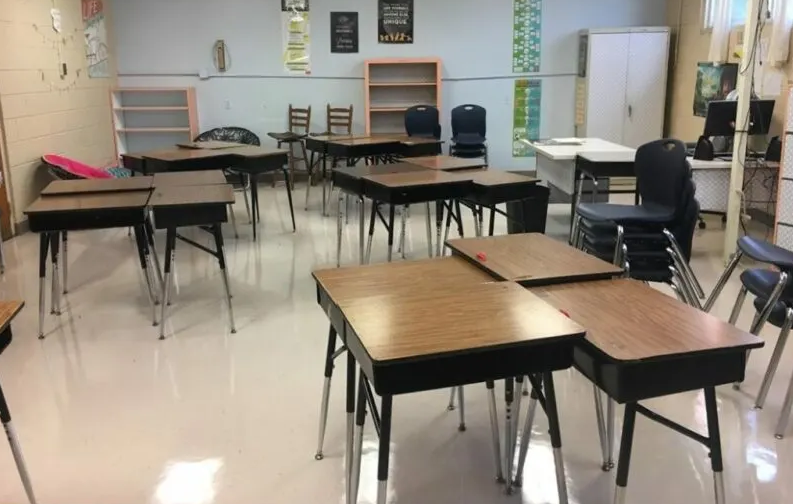

System: You are a VLM designed to detect obstacles to ensure a safe route for self-driving wheelchair users. Please detect any moving objects, slopes, or obstacles in the wheelchair's path
Assistant: Yes, there are obstacles to be aware of.
Runtime:  0.843 seconds



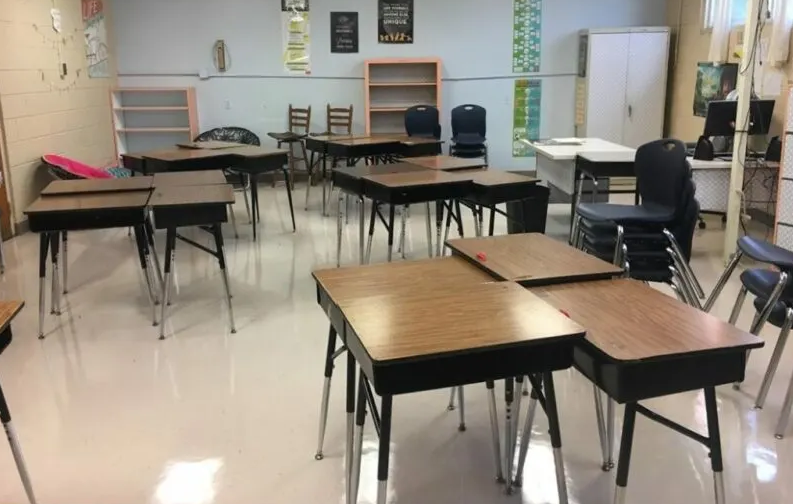

System: You are a helpful VLM designed to detect obstacles to ensure a safe route for self-driving wheelchair users.
Assistant: Yes, there are chairs and desks in the room.
Runtime:  0.89 seconds



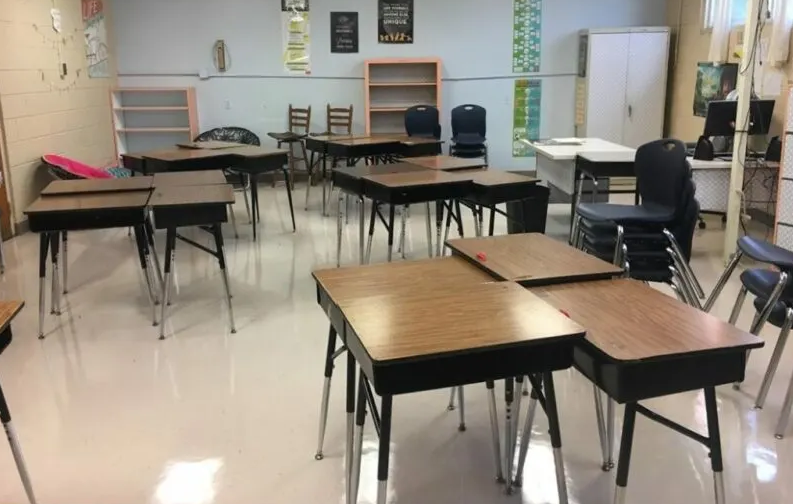

System: You are a helpful VLM designed to detect obstacles to ensure a safe route for self-driving wheelchair users. Please detect any moving objects, slopes, or obstacles in the wheelchair's path
Assistant: Yes, there are chairs in the room.
Runtime:  0.8351 seconds



In [70]:
from PIL import Image
from transformers.image_utils import load_image
from IPython.display import display
import time

# Loop through prompts
for system_prompt in system_prompts:

    # Start
    start_time = time.perf_counter()

    # Load images
    image1 = load_image(example_path)
    display(image1)

    # Create input messages
    messages = [
        {
            "role": "system",
            "content": [
                {"type": "text", "text": system_prompt}
            ]
        },
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": "Going forward, are there any obstacles to be aware of?"}
            ]
        },
    ]

    # Prepare inputs
    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=[image1], return_tensors="pt")
    inputs = inputs.to(DEVICE)

    # Generate outputs
    generated_ids = model.generate(**inputs, max_new_tokens=500)
    generated_texts = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )

    # Print system prompt + assistant response since those are the only manipulations
    print(generated_texts[0].split("\n")[0])
    print(generated_texts[0].split("\n")[-1])

    # End
    end_time = time.perf_counter()
    run_time = end_time - start_time
    print("Runtime: ", round(run_time, 4), "seconds")

    print()

Testing user prompts

In [ ]:
# NOTE: Since the System prompt results look pretty good, I think the current user prompt is fine.

Testing images

In [71]:
image_paths = [good_example_path, bad_example_path]

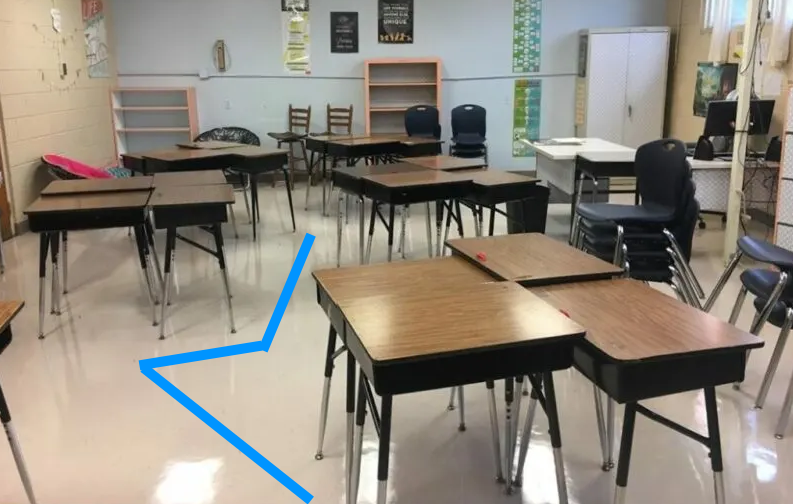

System: You are a VLM designed to detect obstacles to ensure a safe route for self-driving wheelchair users.
<global-img>Consider the blue line drawn on the image as the wheelchair's planned path of motion. This blue line may or may not be a safe path to follow for a self-driving wheelchair. Is the blue line following a clear path?
Assistant: Yes, the blue line is following a clear path.
Runtime:  0.8248 seconds

System: You are a VLM designed to detect obstacles to ensure a safe route for self-driving wheelchair users. Please detect any moving objects, slopes, or obstacles in the wheelchair's path
<global-img>Consider the blue line drawn on the image as the wheelchair's planned path of motion. This blue line may or may not be a safe path to follow for a self-driving wheelchair. Is the blue line following a clear path?
Assistant: Yes, the blue line is following a clear path.
Runtime:  0.8352 seconds

System: You are a helpful VLM designed to detect obstacles to ensure a safe route for 

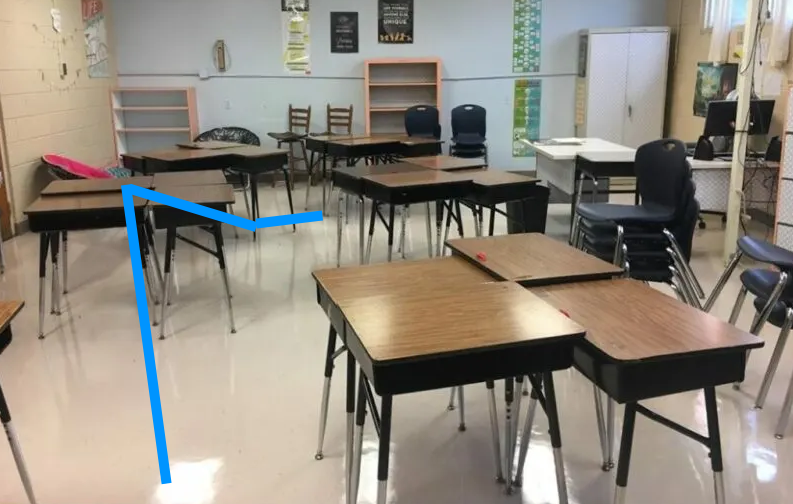

System: You are a VLM designed to detect obstacles to ensure a safe route for self-driving wheelchair users.
<global-img>Consider the blue line drawn on the image as the wheelchair's planned path of motion. This blue line may or may not be a safe path to follow for a self-driving wheelchair. Is the blue line following a clear path?
Assistant: No, the blue line is not following a clear path. It is not following a straight line and is not following a path that is safe for a self-driving wheelchair.
Runtime:  1.3351 seconds

System: You are a VLM designed to detect obstacles to ensure a safe route for self-driving wheelchair users. Please detect any moving objects, slopes, or obstacles in the wheelchair's path
<global-img>Consider the blue line drawn on the image as the wheelchair's planned path of motion. This blue line may or may not be a safe path to follow for a self-driving wheelchair. Is the blue line following a clear path?
Assistant: No, the blue line is not following a clear path

In [ ]:
from PIL import Image
from transformers.image_utils import load_image
from IPython.display import display

# Loop through good and bad paths
for path in image_paths:

    # Load images
    image1 = load_image(path)
    display(image1)

    # Create input messages
    for system_prompt in system_prompts:

        # Start
        start_time = time.perf_counter()

        # Format
        messages = [
            {
                "role": "system",
                "content": [
                    {"type": "text", "text": system_prompt}
                ]
            },
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": "Consider the blue line drawn on the image as the wheelchair's planned path of motion. This blue line may or may not be a safe path to follow for a self-driving wheelchair. Is the blue line following a clear path?"}
                ]
            },
        ]

        # Prepare inputs
        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image1], return_tensors="pt")
        inputs = inputs.to(DEVICE)

        # Generate outputs
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        # Print system prompt + assistant response since those are the only manipulations
        print(generated_texts[0].split("\n")[0])
        print(generated_texts[0].split("\n")[-2])
        print(generated_texts[0].split("\n")[-1])

        # End
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print("Runtime: ", round(run_time, 4), "seconds")

        print()

# Same prompt, try different models

In [ ]:
# NOTE: Since the SmolVLM is offering good inference times + somewhat accurate responses, we'll stick with it.

# Full evaluation

To make our model foolproof for new contexts, we will need to consider a number of variables.
- Input image: snapshot with or without path drawn?
- Model choice: tradeoff between number of parameters vs. inference time
- System prompts: tuned for accuracy
- User prompts: tuned for accuracy


Design a dataset

In [ ]:
# TODO:

Evaluate

In [ ]:
# TODO:

# Encoding and decoding images

In [1]:
image_path='images/example.png'

amazing source: https://www.geeksforgeeks.org/python/python-convert-image-to-string-and-vice-versa/

Image -> Binary

In [33]:
import base64

# Encode the image to a base64 string.
with open(image_path, "rb") as img:
    encoded_bytes = base64.b64encode(img.read())
print(encoded_bytes)
print(type(encoded_bytes))

b'iVBORw0KGgoAAAANSUhEUgAAAxkAAAH4CAYAAAAmZCDxAAcMxElEQVR4nOz9+ZMryZEmCJqZO4AAEHe8M18ePJLFqmJVdbPPbamRlZ2Rnd0f+z/cv2Slu0Vmpkdmurqka5osFlkkM5nJfPeLOwIBwN1s9FNVMzd3AIGIeC8Psp6RkXgAHH7Yoaaqn+qn5c////+/YKhZa411ll/RnL7G5lzReo/jvPfG02Eh+Oxz1zqGfmmCD3RsbWo6nk6cfZcdr5+HEFrn86Hme/Eh6Hurr/I+WDl2Xk3N2dmZmUwmdK/OPHr4iD6bm9msMnVV8/VwbvqhqWv6rKZ7x33Vch3cG+4T15Z7CPqZ5c9qI9ezOIb++MnqYC7Pzs2zr74yJ68Oja8q/qzs9UyvV2qfyfOVRWH6ww3us8uLSzPeHPM56yqYin5X2dpUdB3c+4COKwYbxhQlHeFMTc9MT8B3wP2NPzq3x7nTa4kPTWFknAqj/Rn7O/avD633sRU6vs24yGvRee/1eYpicT4se+1+322rPo8N/dFu/trzp1d3s+uvvK511/5+5fXd8ue/6fkWPndr7ju0zxt0Xaxr6TrWt3/vw8K58nN62/0ujofchwvt80+nE/O//K//i/n1r39tNjY2zJMnj82PfvQj88knH9L7IX92dXVFzxlMryzNdDYxX3311Mznc7O/v2MuJ1Nz//59WqeyLvv9nsmf/fXrI/Pzn/+c135F6/qTj79vPv74YzMaj3htFb2Bue75sb6i7LtJf5EUa71f1+I6bJrrfC/vfecwFXNLft+5r/Qvr2Phk6yGnEN79vy5+Zv/8l+4Xy8vL/jeq7o289mM5JE1ZVnw+MkzST8vW0f4zHlHIsfRWPX4FfPah84cCoHHi7+nMUXDeNZ0Taznv/qrvzT/7t/9O5IhpbFFuz+inE291ZlP3eZCu//SuN5wuVvr1ny/bl4U1x4fv4/7qTXt9RLMOrnQPr/xN1vfcV03R8t1pH

Binary -> Image

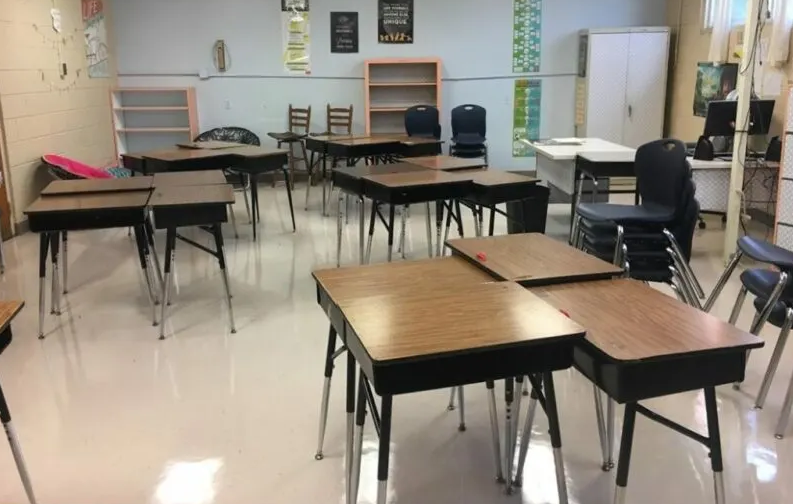

In [34]:
import base64
from PIL import Image
from transformers.image_utils import load_image
from IPython.display import display
import io


# TODO: There might be a faster way of doing this

# Decode the image & convert it to PIL
decoded_bytes = base64.b64decode(encoded_bytes)
image_bytes = io.BytesIO(decoded_bytes)
pil_image = Image.open(image_bytes)
image1 = load_image(pil_image)
display(image1)